In [1]:
import sys
sys.path.append('../../sparsedense/')

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import importlib
from statsmodels.nonparametric.kde import KDEUnivariate
from collections import Counter
import pandas as pd
from networkx.algorithms import approximation

In [3]:
import optim as opt
import helpertests as tst
import sparsedense as spd

In [4]:
importlib.reload(tst)

<module 'helpertests' from '../../sparsedense\\helpertests.py'>

In [5]:
test = 'facebook'

In [6]:
links = np.genfromtxt('{}.txt'.format(test), delimiter=' ', dtype=int)
g = nx.Graph()
g.add_edges_from(links)
net = nx.adjacency_matrix(g).toarray().astype(int)
for i in range(net.shape[0]):
    net[i, i] = 1
    

In [7]:
# with open('{}_clique_init.pkl'.format(test, suffix), 'rb') as f:
#     runs = pickle.load(f)

# alpha, sigma, c, num_cliques = runs['alphas'][-1], runs['sigmas'][-1], runs['cs'][-1], runs['Ks'][-1]
# alpha, sigma, c, num_cliques

In [8]:
def gen_rcc_samples(nreps, alpha, sigma, c, num_cliques):
    for k in range(nreps):
        Z = opt.sample_from_ibp(num_cliques, alpha=alpha, sigma=sigma, c=c)
        net = Z.transpose() @ Z
        K, N = Z.shape
        links = []
        for i in range(N - 1):
            for j in range(i + 1, N):
                if net[i, j] >= 1:
                    links.append([i, j])
        np.savetxt('rcc_runs/{}.tsv'.format(k), np.array(links), delimiter='\t', fmt='%d')

In [9]:
with open('facebookc300.pkl', 'rb') as fn:
    model = pickle.load(fn)
    alpha = model.alpha
    sigma = model.sigma
    c = model.c
    num_cliques = model.num_cliques

In [10]:
# nreps = 25
# gen_rcc_samples(nreps, alpha, sigma, c, num_cliques)

In [11]:
def test_samples(path, n=25, mc_size=500, verbose=True, offset=0, zeropad=False, nodeoffset=0):
    
    num_nodes, num_edges, edge_node, density, deg, max_clique_node, clust_coeff, conn_comp_largest, short_paths, triang_node = \
        [], [], [], [], [], [], [], [], [], []
    
    for i in range(1, n):
        strpattern = '{}.tsv' if not zeropad else '{:02d}.tsv'
        links = np.genfromtxt(path + strpattern.format(i+offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        for i, j in links:
            if i != j:
                g.add_edge(i - nodeoffset, j - nodeoffset)

        num_nodes_i, num_edges_i, edge_node_ratio_i, density_i, deg_i, max_clique_node_i, clust_coeff_i, conn_comp_i, short_paths_i, triang_node_i = \
            tst.test_stats(g, mc_size=mc_size, verbose=False, return_results=True)

        num_nodes.append(num_nodes_i)
        num_edges.append(num_edges_i)
        edge_node.append(edge_node_ratio_i)
        density.append(density_i)
        deg.append(deg_i)
        max_clique_node.append(max_clique_node_i)
        clust_coeff.append(clust_coeff_i)
        conn_comp_largest.append(conn_comp_i / num_nodes_i)
        short_paths.append(short_paths_i)
        triang_node.append(triang_node_i)
        
    if verbose:
        print("- num nodes: {:f}, {:f}".format(np.mean(num_nodes), np.std(num_nodes)))
        print("- num edges: {:f}, {:f}".format(np.mean(num_edges), np.std(num_edges)))
        print("- edge node ratio: {:2.2f}, {:f}".format(np.mean(edge_node), np.std(edge_node)))
        print("- triang node ratio: {:f}, {:f}".format(np.mean(triang_node), np.std(triang_node)))
        print("- density (1000x): {:2.6f}, {:f}".format(1000 * np.mean(density), 1000 * np.std(density)))
        print("- mean degree: {:2.2f}, {:f}".format(np.mean(deg), np.std(deg)))
        print("- mean maximal clique containing node: {:2.2f}, {:f}".format(np.mean(max_clique_node), np.std(max_clique_node)))
        print("- clustering coefficient: {:2.2f}, {:f}".format(np.mean(clust_coeff), np.std(clust_coeff)))
        print("- connected component sizes (largest): {}, {:f}".format(np.mean(conn_comp_largest), np.std(conn_comp_largest)))
        print("- mean distance between nodes (largest conn. comp.): {:2.2f}, {:f}".format(np.mean(short_paths), np.std(short_paths)))  

In [12]:
tst.test_stats(g, mc_size=200) 

- num nodes: 4039
- num edges: 88234
- edge node ratio: 21.85
- triang node ratio: 356.36
- density: 0.010820
- mean degree: 43.69
- clustering coefficient: 0.60
- mean maximal clique containing node: 15.98
- connected component sizes (top 5): [4039]
- mean distance between nodes (largest conn. comp.): 0.00


In [13]:
test_samples('rcc_runs/', n=25, mc_size=200)

- num nodes: 4003.791667, 63.318625
- num edges: 96123.125000, 6115.731908
- edge node ratio: 24.00, 1.303611
- triang node ratio: 211.815347, 71.238103
- density (1000x): 11.988518, 0.580899
- mean degree: 48.00, 2.607223
- mean maximal clique containing node: 7.27, 0.538774
- clustering coefficient: 0.42, 0.042653
- connected component sizes (largest): 0.9995948750854273, 0.000424
- mean distance between nodes (largest conn. comp.): 0.00, 0.000000


In [14]:
test_samples('bnpgraph_runs/facebook_', offset=1, n=25, mc_size=200, nodeoffset=1)

- num nodes: 4056.125000, 92.765975
- num edges: 91043.458333, 6184.963244
- edge node ratio: 22.43, 1.125870
- triang node ratio: 35.187153, 7.001171
- density (1000x): 11.058124, 0.418401
- mean degree: 44.86, 2.251740
- mean maximal clique containing node: 3.64, 0.093437
- clustering coefficient: 0.05, 0.017349
- connected component sizes (largest): 0.999917187282306, 0.000185
- mean distance between nodes (largest conn. comp.): 0.00, 0.000000


In [15]:
test_samples('krongen_runs/facebook_', offset=1, n=25,  zeropad=True, mc_size=200)

- num nodes: 4096.000000, 0.000000
- num edges: 72659.208333, 29.410853
- edge node ratio: 17.74, 0.007180
- triang node ratio: 4.769722, 0.503244
- density (1000x): 8.663768, 0.003507
- mean degree: 35.48, 0.014361
- mean maximal clique containing node: 3.11, 0.032218
- clustering coefficient: 0.02, 0.010793
- connected component sizes (largest): 1.0, 0.000000
- mean distance between nodes (largest conn. comp.): 0.00, 0.000000


In [29]:
def fit_kde(x, grid):
    resol = len(grid)
    d = np.zeros(resol)
    kde = KDEUnivariate(x)
    kde.fit()
    d = kde.evaluate(grid)    
    return d

def fit_count(x, grid):
    cnt = Counter(x)
    d = np.array([cnt[y] for y in grid]) / len(x)
    return d

def degree_clique_density_runs(path, deg_grid, clique_grid, n = 25, offset=0, zeropad=False, nodeoffset=0):
    deg_dens = np.zeros(len(deg_grid))
    clique_dens = np.zeros(len(clique_grid))
    
    for k in range(n):
        strpattern = '{}.tsv' if not zeropad else '{:02d}.tsv'
        links = np.genfromtxt(path + strpattern.format(k+offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        for i, j in links:
            if i != j:
                g.add_edge(i - nodeoffset, j - nodeoffset)



        degs = np.array([nx.degree(g, i) for i in g.nodes()], dtype=float)
        clique = np.zeros(g.number_of_nodes()) # np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)
        
        deg_dens += fit_kde(degs, deg_grid) / n  
        clique_dens += fit_count(clique, clique_grid) / n  
        
    return deg_dens, clique_dens

def degree_clique_density_graph(g, deg_grid, clique_grid):
    degs = np.array([nx.degree(g, i) for i in g.nodes()], dtype=float)
    clique = np.zeros(g.number_of_nodes()) # np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)

    deg_dens = fit_kde(degs, deg_grid)
    clique_dens = fit_count(clique, clique_grid) 
        
    return deg_dens, clique_dens

In [29]:
deg_grid = np.linspace(1, 150, 150)
clique_grid = np.arange(2, 20)

deg_dens_rcc, clique_dens_rcc = degree_clique_density_runs('rcc_runs/', deg_grid, clique_grid)
deg_dens_bnp, clique_dens_bnp = degree_clique_density_runs('bnpgraph_runs/facebook_', deg_grid, clique_grid, offset=1, nodeoffset=1)
deg_dens_krongen, clique_dens_krongen = degree_clique_density_runs('krongen_runs/facebook_', deg_grid, clique_grid, offset=1, zeropad=True)

In [30]:
deg_dens_orig, clique_dens_orig = degree_clique_density_graph(g, deg_grid, clique_grid)

In [31]:
deg_df = pd.DataFrame({
    'Truth': deg_dens_orig, 
    'RCC': deg_dens_rcc, 
    'BNPGraph': deg_dens_bnp,
    'Kron(2x2)': deg_dens_krongen}, index=deg_grid)
maxclique_df = pd.DataFrame({
    'Truth': clique_dens_orig, 
    'RCC': clique_dens_rcc,
    'BNPGraph': clique_dens_bnp,
    'Kron(2x2)': clique_dens_krongen}, index=clique_grid)

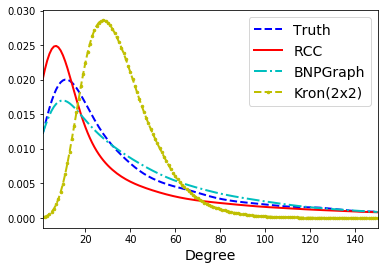

In [32]:
style = ['b--','r-','c-.', 'y--.']
deg_df.plot(style=style, markersize=5, linewidth=2, figsize = (6, 4))
plt.legend(fontsize=14) # using a size in points
plt.xlim(1, 150)
plt.xlabel("Degree", fontsize=14)
# plt.ylabel("Density")
# plt.title("Degree distribution")
plt.savefig('facebook_degree_dist.png', format="PNG")
plt.show()

In [ ]:
def fit_count(x, grid):
    cnt = Counter(x)
    d = np.array([cnt[y] for y in grid]) / len(x)
    return d

def clique_density_runs(path, clique_grid, n = 25, offset=0, zeropad=False, nodeoffset=0):
    counts = np.zeros((len(clique_grid), n))
    
    for k in range(n):
        strpattern = '{}.tsv' if not zeropad else '{:02d}.tsv'
        links = np.genfromtxt(path + strpattern.format(k+offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        for i, j in links:
            if i != j:
                g.add_edge(i - nodeoffset, j - nodeoffset)

        clique = np.array([nx.node_clique_number(g, i) for i in np.random.choice(g.nodes(), 500)], dtype=float)    
        counts[:,k] = fit_count(clique, clique_grid)
    
    means = np.mean(counts, 1)
    std = np.std(counts, 1)
        
    return means, std, counts

def clique_density_graph(g, clique_grid, n = 25, offset=0):
    clique = [nx.node_clique_number(g, i) for i in np.random.choice(g.nodes(), 100)]
    counts = fit_count(clique, clique_grid)
    
    return counts

In [ ]:
clique_means_rcc

In [ ]:
clique_std_rcc

In [ ]:
clique_grid = np.arange(2, 20)
clique_means_rcc, clique_std_rcc = clique_density_runs('rcc_runs/', clique_grid)
clique_means_bnp, clique_std_bnp = clique_density_runs('bnpgraph_runs/facebook_', clique_grid, offset=1, nodeoffset=1)
clique_means_krongen, clique_std_krongen = clique_density_runs('krongen_runs/facebook_', clique_grid, offset=1, zeropad=True)
clique = clique_density_graph(g, clique_grid)
df = pd.DataFrame({'Truth': clique, 'RCC': clique_means_rcc, 'BNPGraph': clique_means_bnp, 'Kron(2x2)': clique_means_krongen}, index=clique_grid)

In [ ]:
style = ['b','r','c', 'y']
df.plot.bar(width=.8, figsize=(6,4), alpha=0.7, rot=0, color=style, edgecolor = 'black')
plt.legend(fontsize=14)
plt.xlabel('Maximal clique size per node', fontsize=14)
plt.savefig('facebook_maximal_clique_dist.png', format="PNG")

In [ ]:
clique_grid